In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install pennylane

In [3]:

import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



from IPython.display import clear_output
clear_output(wait=False)

import os



In [4]:
data_train = pd.read_csv(r"C:\Users\sreek\Desktop\fair_train.csv")
X_train,y_train = data_train[data_train.columns[:16]].values, data_train[data_train.columns[16]].values

data_test = pd.read_csv(r"C:\Users\sreek\Desktop\classic_test.csv")
X_test,y_test = data_test[data_test.columns[:16]].values, data_test[data_test.columns[16]].values

(X_train.shape, y_train.shape),(X_test.shape, y_test.shape)

(((2000, 16), (2000,)), ((6159, 16), (6159,)))

In [5]:
scale = StandardScaler()
scale.fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

In [6]:
dev = qml.device("default.qubit", wires=4)

In [7]:
def layer_1(W):

    qml.RY(W[0], wires=0)
    qml.RY(W[1], wires=1)
    qml.RY(W[2], wires=2)
    qml.RY(W[3], wires=3)


    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=3)

    qml.RZ(W[4], wires=0)
    qml.RZ(W[5], wires=1)
    qml.RZ(W[6], wires=2)
    qml.RZ(W[7], wires=3)


    qml.CNOT(wires=[1,0])
    qml.RY(W[8], wires=1)
    qml.CNOT(wires=[2,0])
    qml.RY(W[9], wires=2)
    qml.CNOT(wires=[3,0])
    qml.RY(W[10], wires=3)

    qml.CNOT(wires=[2,1])
    qml.RY(W[11], wires=2)
    qml.CNOT(wires=[3,1])
    qml.RY(W[12], wires=3)


In [8]:
def block(weights, wires):
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])

n_wires = 4
n_block_wires = 2
n_params_block = 2
n_blocks = qml.MPS.get_n_blocks(range(n_wires),n_block_wires)
n_blocks

3

In [9]:
@qml.qnode(dev)
def circuit(weights, x):
    qml.AmplitudeEmbedding(x, wires=[0,1,2,3],normalize=True,pad_with=True)
    for w in weights:
        qml.MPS(range(n_wires),n_block_wires,block, n_params_block, w)
    return qml.expval(qml.PauliZ(3))

In [10]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)



In [11]:
np.random.seed(0)
num_layers = 1
weights_init = 2*np.pi * np.random.randn(num_layers,3, 2, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print(weights_init, bias_init)

[[[11.08386778  2.51426189]
  [ 6.14959212 14.07994722]
  [11.73421292 -6.14041802]]] 0.0


In [12]:
print(qml.draw(circuit,expansion_strategy='device',wire_order=[0,1,2,3,4,5,6,7])(weights_init,np.asarray(X_train[0])))

0: ─╭|Ψ⟩─╭●──RY(11.08)─────────────────────────────┤     
1: ─├|Ψ⟩─╰X──RY(2.51)──╭●──RY(6.15)────────────────┤     
2: ─├|Ψ⟩───────────────╰X──RY(14.08)─╭●──RY(11.73)─┤     
3: ─╰|Ψ⟩─────────────────────────────╰X──RY(-6.14)─┤  <Z>


In [13]:
for i in weights_init:
    print(i[0])

[11.08386778  2.51426189]


In [14]:
y_train = np.where(y_train < 1, -1, y_train)
y_test = np.where(y_test < 1, -1, y_test)

In [15]:
from sklearn.utils import shuffle
X,y = shuffle(X_train, y_train, random_state=0)


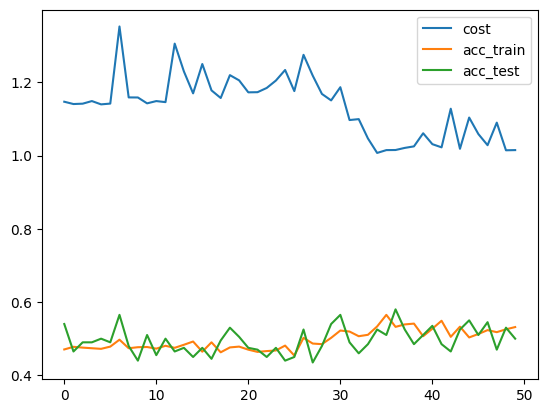

Iter:    50 | Cost: 1.0147624 | Acc train: 0.5316667 | Acc validation: 0.5000000 
[[[11.08386778  1.65722595]
  [ 6.14959212 15.779971  ]
  [11.73421292 -2.91845704]]]


In [16]:
from sklearn.model_selection import train_test_split

opt = NesterovMomentumOptimizer(0.4)
batch_size = 32

num_data = len(y_train)
num_train = 0.9
weights = weights_init
bias = bias_init
print()

cost_g = []
acc_train = []
acc_test = []
plt.show()
for it in range(50):
    X_train_70, X_test_30, y_train_70, y_test_30 =train_test_split(np.asarray(X), np.asarray(y), train_size=num_train, test_size=1.0-num_train, shuffle=True)
    batch_index = np.random.randint(0, len(X_train_70), (batch_size,))
    feats_train_batch = X_train_70[batch_index]
    Y_train_batch = y_train_70[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch.astype(np.float64), Y_train_batch.astype(np.float64))
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in X_train_70]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in X_test_30]
    acc_tra = accuracy(y_train_70, predictions_train)
    acc_val = accuracy(y_test_30, predictions_val)
    cost_train = cost(weights, bias,X_train, y_train)
    cost_g.append(cost_train)
    
    acc_train.append(acc_tra)
    acc_test.append(acc_val)
    
    clear_output(wait=True)
    plt.plot(cost_g,label='cost')
    plt.plot(acc_train,label='acc_train')
    plt.plot(acc_test,label='acc_test')
    plt.legend(['cost','acc_train','acc_test'])
    plt.show()
     
    
    print(
         "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
         "".format(it + 1, cost_train, acc_tra, acc_val)
     )
    print(weights)

In [17]:
x_test = []
for x in X_test.tolist():
    if sum(x) == 0:
        x[0]=1
    x_test.append( x/ np.linalg.norm(x))
x_test[0]

array([-0.06068524,  0.15253362, -0.05088817, -0.08791603, -0.09414174,
       -0.09374645, -0.06247694, -0.06234874, -0.06613489, -0.07573516,
       -0.04638137, -0.05568809,  0.61580063,  0.68356737, -0.06412831,
        0.26709724])

In [18]:
y_pred = [np.sign(variational_classifier(weights, bias, f)) for f in x_test]


In [19]:
y_test_pred = []
for i in y_pred:
    if i < 0:
        y_test_pred.append(-1)
    else:
        y_test_pred.append(1)

Accuracy: 0.532067
Precision: 0.184826
Recall: 0.455270
F1 score: 0.262916
Cohens kappa: 0.002918
ROC AUC: 0.502287
[[2763 2267]
 [ 615  514]]


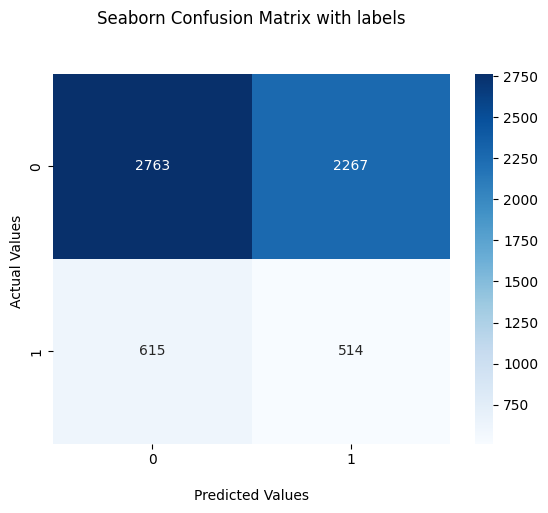

In [20]:

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

accuracy = accuracy_score(y_test, y_test_pred)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, y_test_pred)
print('Precision: %f' % precision)
recall = recall_score(y_test, y_test_pred)
print('Recall: %f' % recall)
f1 = f1_score(y_test, y_test_pred)
print('F1 score: %f' % f1)
kappa = cohen_kappa_score(y_test, y_test_pred)
print('Cohens kappa: %f' % kappa)
auc = roc_auc_score(y_test, y_test_pred)
print('ROC AUC: %f' % auc)
test_matrix = confusion_matrix(y_test, y_test_pred)
print(test_matrix)
ax = sns.heatmap(test_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
plt.show()

In [21]:
y_pred_1 = [int(i) for i in y_pred ]
y_pred_1 = ["{}\n".format(i) for i in y_pred_1]
with open(r'mps_1_layers_std.csv', 'w') as fp:
    fp.writelines(y_pred_1)